In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

2023-04-29 14:33:01.889493: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 14:33:01.913084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 14:33:02.025179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 14:33:02.025836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 14:33:02.669310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = 'V'

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current/y_test_AE_' + wireplane + '.npy')


mean = np.load('../results/'+wireplane+'/models/mean_AE_'+wireplane+'.npy')
std = np.load('../results/'+wireplane+'/models/std_AE_'+wireplane+'.npy')

In [4]:
x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

In [5]:
max_adcs_test_signals = [max(abs(wave)) for wave in y_test if sum(abs(wave) != 0)]
print(sum(1 for val in max_adcs_test_signals if val < 20 and val !=0), len(max_adcs_test_signals))

18207 50000


In [6]:
len(max_adcs_test_signals)

50000

In [7]:
def custom_mse2(y_true, y_pred):

    return -1

In [8]:
cnn = load_model('../../latest_models/model_'+wireplane+'plane_nu.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

ae1 = load_model('../results/' + wireplane + '/models/batch_size1_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})

ae128 = load_model('../results/' + wireplane + '/models/batch_size128_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})

ae256 = load_model('../results/' + wireplane + '/models/batch_size256_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})

ae512 = load_model('../results/' + wireplane + '/models/batch_size512_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})

ae1024 = load_model('../results/' + wireplane + '/models/batch_size1024_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})


25/25 [==============================] - 0s 13ms/step


In [9]:
%%time

predictions1 = ae1.predict(x_test_scaled, batch_size=4096)


predictions128 = ae128.predict(x_test_scaled, batch_size=4096)
predictions128 = predictions128.reshape(predictions128.shape[0], predictions128.shape[1])

predictions256 = ae256.predict(x_test_scaled, batch_size=4096)
predictions256 = predictions256.reshape(predictions256.shape[0], predictions256.shape[1])

predictions512 = ae512.predict(x_test_scaled, batch_size=4096)
predictions512 = predictions512.reshape(predictions512.shape[0], predictions512.shape[1])

predictions1024 = ae1024.predict(x_test_scaled, batch_size=4096)
predictions1024 = predictions1024.reshape(predictions1024.shape[0], predictions1024.shape[1])



25/25 [==============================] - 1s 39ms/step
CPU times: user 18.7 s, sys: 1.07 s, total: 19.8 s
Wall time: 6.5 s


In [10]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_ = y_test_scaled*std + mean

pred1= predictions1*std + mean
pred1 = pred1-stats.mode(pred1[0], keepdims=False)[0]

pred128 = predictions128*std + mean

pred256 = predictions256*std + mean

pred512 = predictions512*std + mean

pred1024 = predictions1024*std + mean

In [11]:
noise_data = [data for data in y_test_ if sum(abs(data)) == 0]

In [12]:
len(noise_data)

50000

In [13]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [14]:
pred_labels1 = [label_predictions(wave) for wave in pred1]
pred_labels128 = [label_predictions(wave) for wave in pred128]

pred_labels256 = [label_predictions(wave) for wave in pred256]
pred_labels512 = [label_predictions(wave) for wave in pred512]
pred_labels1024 = [label_predictions(wave) for wave in pred1024]

truth_labels = [label_truths(t_wave) for t_wave in y_test]

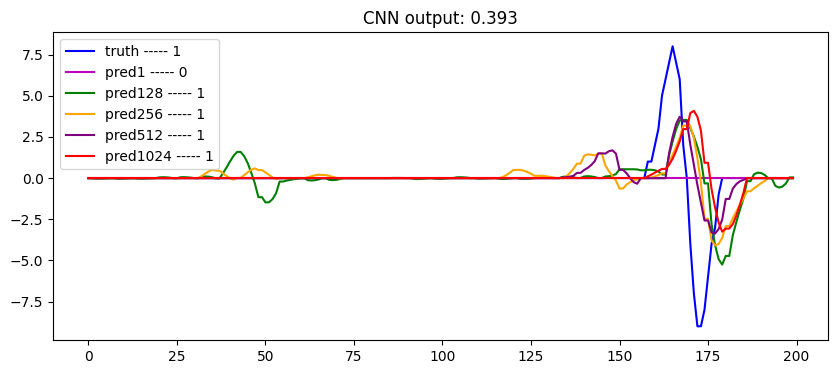

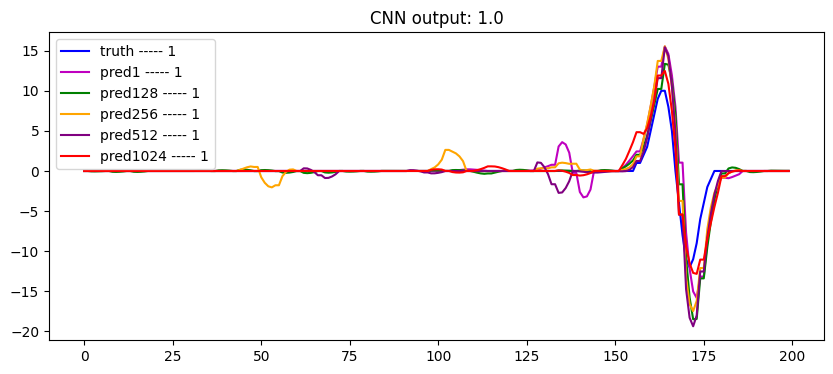

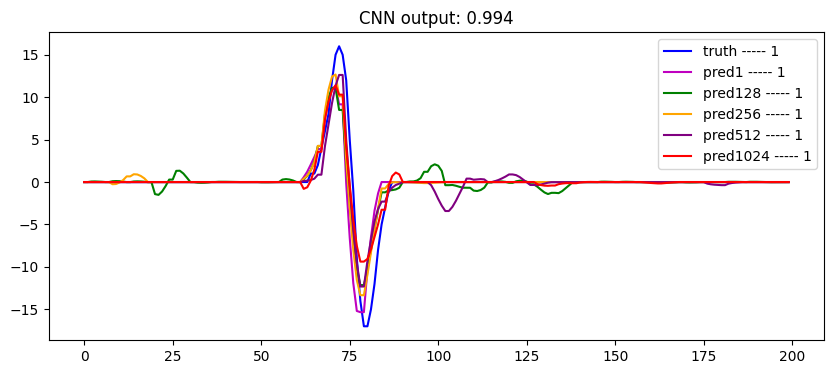

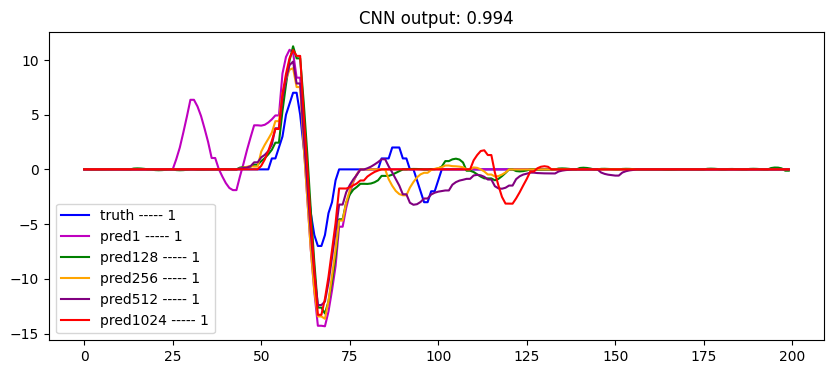

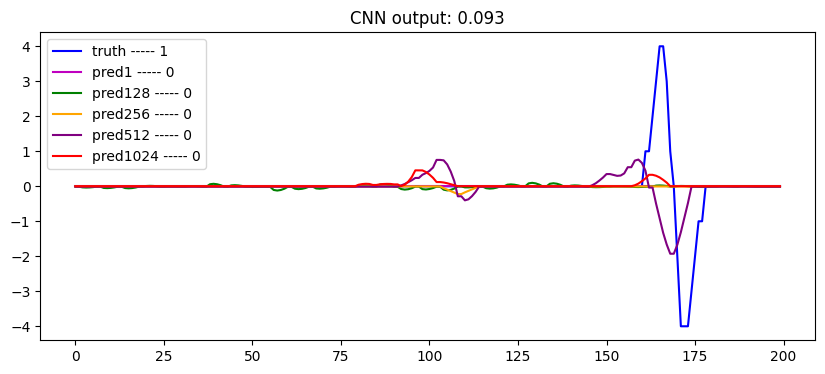

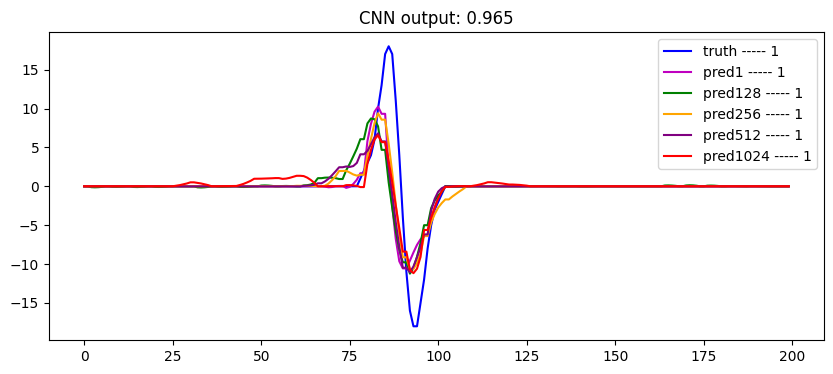

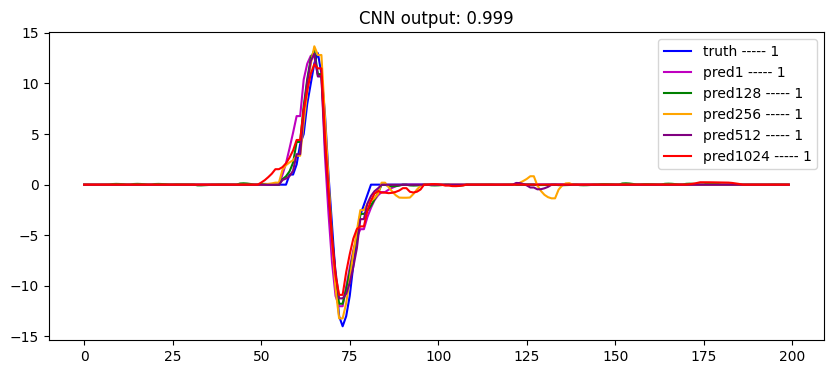

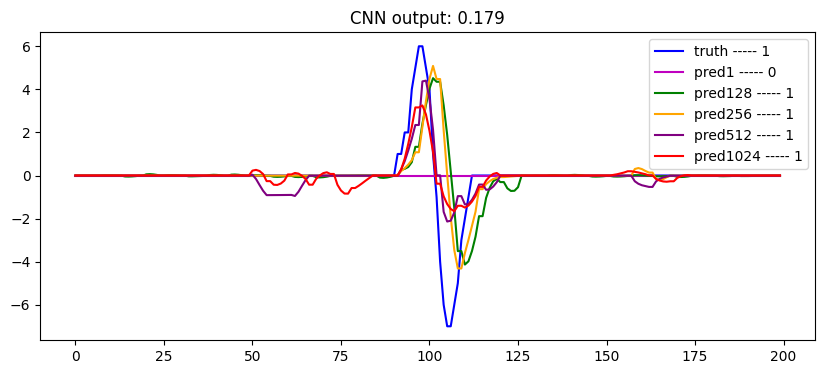

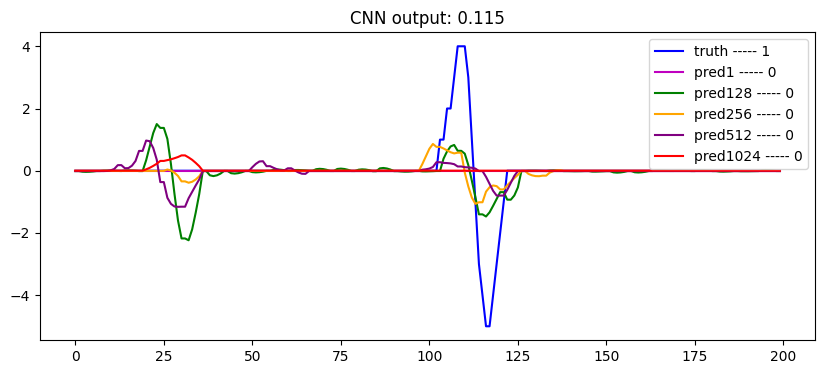

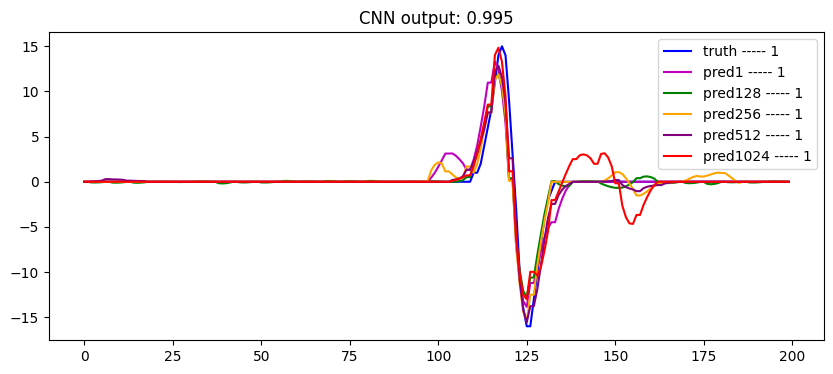

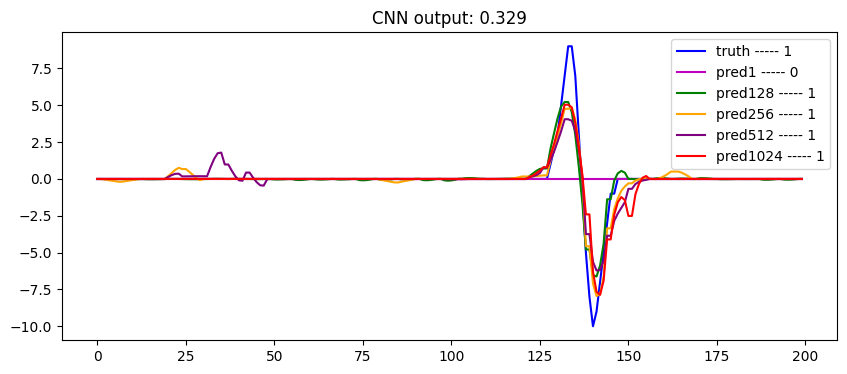

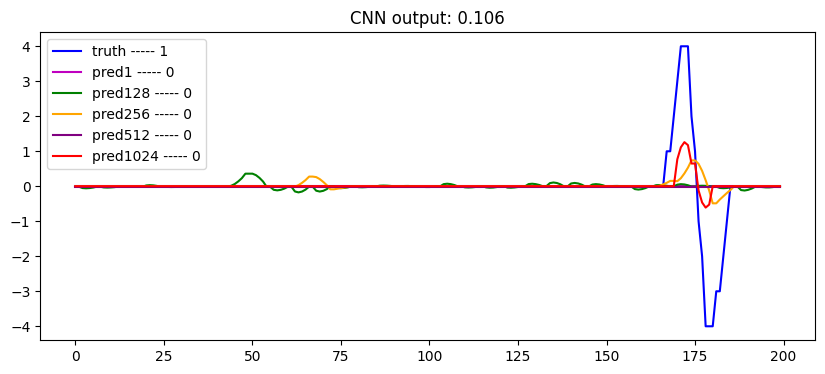

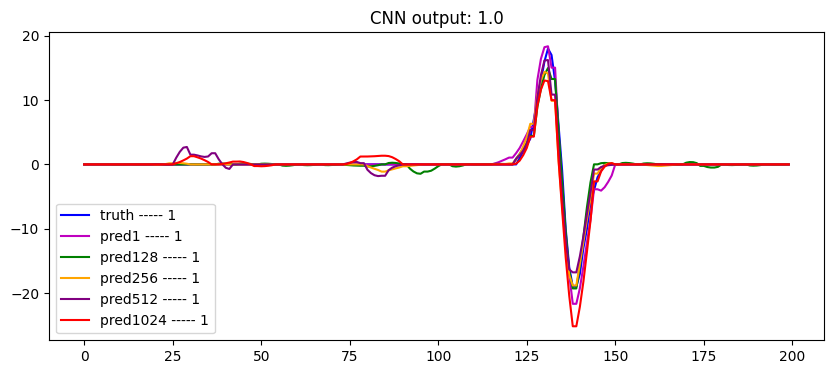

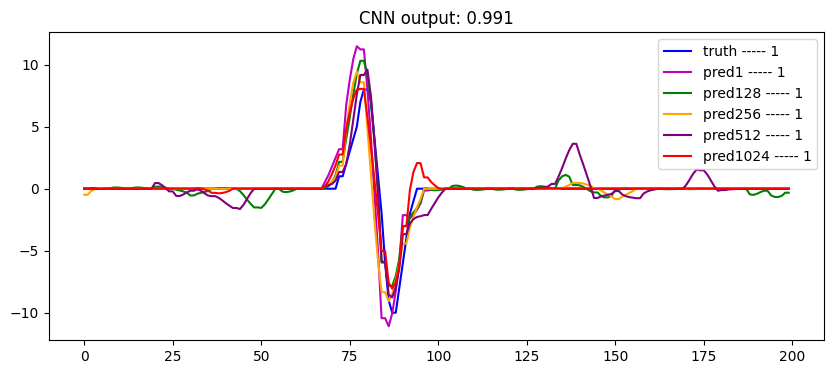

In [15]:
for i in range(100):
    if max(abs(y_test_[i])) < 20 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(10,4))
        plt.plot(y_test_[i], color='blue', label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred1[i], color='m', label='pred1 ----- ' + str(pred_labels1[i]))
        plt.plot(pred128[i], color='green', label='pred128 ----- ' + str(pred_labels128[i]))
        plt.plot(pred256[i], color='orange', label='pred256 ----- ' + str(pred_labels256[i]))
        plt.plot(pred512[i], color='purple', label='pred512 ----- ' + str(pred_labels512[i]))
        plt.plot(pred1024[i], color='red', label='pred1024 ----- ' + str(pred_labels1024[i]))
        plt.title('CNN output: ' + str( round(cnn_pred[i], 3)))
        plt.legend()
        plt.show()


In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr1, tpr1, thresholds1 = roc_curve(truth_labels, pred_labels1, drop_intermediate=False)
roc_auc1 = auc(fpr1, tpr1)

fpr128, tpr128, thresholds128 = roc_curve(truth_labels, pred_labels128, drop_intermediate=False)
roc_auc128 = auc(fpr128, tpr128)

fpr256, tpr256, thresholds256 = roc_curve(truth_labels, pred_labels256, drop_intermediate=False)
roc_auc256 = auc(fpr256, tpr256)

fpr512, tpr512, thresholds512 = roc_curve(truth_labels, pred_labels512, drop_intermediate=False)
roc_auc512 = auc(fpr512, tpr512)

fpr1024, tpr1024, thresholds1024 = roc_curve(truth_labels, pred_labels1024, drop_intermediate=False)
roc_auc1024 = auc(fpr1024, tpr1024)


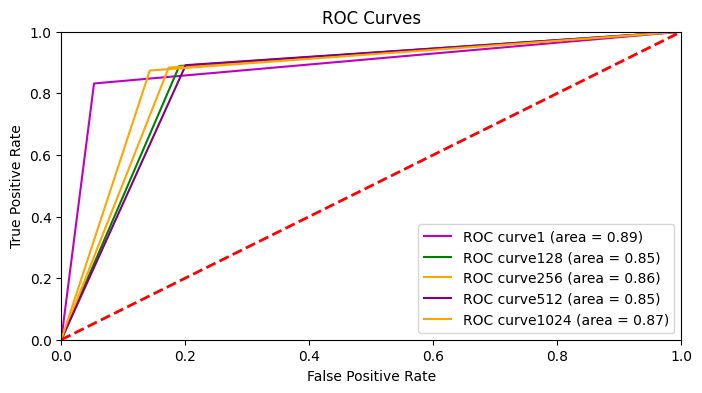

In [17]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr1, tpr1, color='m', label='ROC curve1 (area = %0.2f)' % roc_auc1)
plt.plot(fpr128, tpr128, color='green', label='ROC curve128 (area = %0.2f)' % roc_auc128)
plt.plot(fpr256, tpr256, color='orange', label='ROC curve256 (area = %0.2f)' % roc_auc256)
plt.plot(fpr512, tpr512, color='purple', label='ROC curve512 (area = %0.2f)' % roc_auc512)
plt.plot(fpr1024, tpr1024, color='orange', label='ROC curve1024 (area = %0.2f)' % roc_auc1024)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [24]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) == 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) == 0):
                    break
        wave_idx = index_


        #axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        axes[i].plot(pred1[index_], color='m', label='model_1      ---   ' + str(pred_labels1[index_]))
        axes[i].plot(pred128[index_], color='green', label='model_128  ---   ' + str(pred_labels128[index_]))
        axes[i].plot(pred256[index_], color='orange', label='model_256  ---   ' + str(pred_labels256[index_]))
        axes[i].plot(pred512[index_], color='purple', label='model_512  ---   ' + str(pred_labels512[index_]))
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('pdfs/tmp_plts/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [25]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = 'pdfs/tmp_plts/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('pdfs/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages_NOISE.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [26]:
make_complete_pdf(7, 0.94, 1)

['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']


In [27]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_


['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page8.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']
['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page8.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']
['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_p